<a href="https://colab.research.google.com/github/visiont3lab/deep-learning-course/blob/main/colab/ConvolutionClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution neural network cifar-10 example

## Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader,Dataset
from torch import optim
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import cv2
import torch.nn as nn
import os
from PIL import Image
import pandas as pd
import cv2
import numpy as np

## Download Dataset


## Cifar-10 Dataset

* [Pytorch Cifar 10 dataset Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
* [Paper with code Image classification Cifar dataset](https://paperswithcode.com/sota/image-classification-on-cifar-10)

In [3]:
# Cifar-10 and Cifar-100 https://www.cs.toronto.edu/~kriz/cifar.html

# Bash download
#!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#!tar -xvzf cifar-10-python.tar.gz

# Darknet cifar png dataset
#!wget http://pjreddie.com/media/files/cifar.tgz
#!tar xzf cifar.tgz

# Pytorch download
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True)
#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

# Raw images download
!git clone https://github.com/YoongiKim/CIFAR-10-images.git

Cloning into 'CIFAR-10-images'...
remote: Enumerating objects: 60027, done.
remote: Total 60027 (delta 0), reused 0 (delta 0), pack-reused 60027
Receiving objects: 100% (60027/60027), 19.94 MiB | 64.62 MiB/s, done.
Resolving deltas: 100% (59990/59990), done.
Checking out files: 100% (60001/60001), done.


tensor([0, 1, 9, 4, 3, 8, 2, 2, 5, 0])


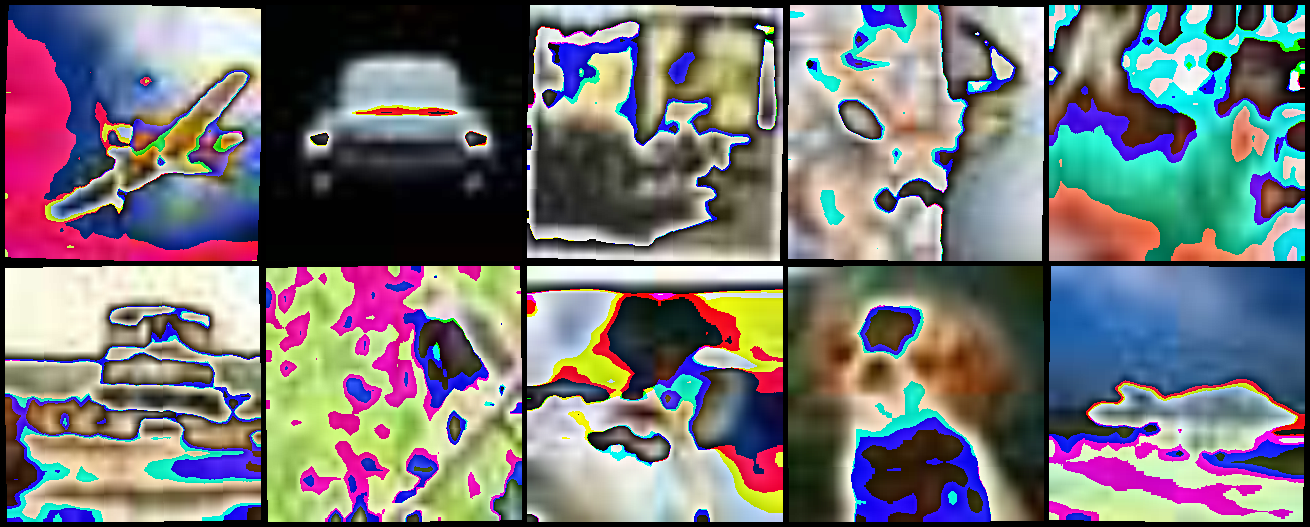

In [16]:
folder_train_path = os.path.join("CIFAR-10-images","train")
folder_test_path = os.path.join("CIFAR-10-images","test")
classes = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,  'dog': 5,  'frog':6, 'horse':7, 'ship':8, 'truck':9}

train_transform = transforms.Compose([                                    
                                    #transforms.ToPILImage(),  # Tensor of Numpy array to Pillow
                                    transforms.Resize((256,256)),
                                    #transforms.RandomApply([
                                    #    transforms.ColorJitter(brightness=0.5,contrast=0.3),
                                    #], p=0.5),
                                    transforms.RandomApply([
                                        transforms.RandomAffine(degrees=3)
                                    ], p=0.5),
                                    transforms.RandomHorizontalFlip(p=0.5), # Pillow transformation
                                    transforms.ToTensor(),          # Pillow to tensor [0-1]
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])   
test_transform = transforms.Compose([      
                                    transforms.Resize((256,256)),                              
                                    transforms.ToTensor(),          # Pillow to tensor [0-1]
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])  
class ImageDataset(Dataset):
    def __init__(self, folder_path,classes,transform=None):
        names = os.listdir(folder_path) 
        self.filepaths = []
        self.y = []
        for c in classes.keys():
            folder_class = os.path.join(folder_path,c)
            names = os.listdir(folder_class)
            f = [os.path.join(folder_path,c,name) for name in names]
            self.filepaths.extend(f)
            self.y.extend([classes[c] for i in range(0,len(f))])
        self.transform = transform
    def __getitem__(self, index):
        filepath = self.filepaths[index]
        y = self.y[index]
        x = Image.open(filepath)
        #m = np.array(x)
        #print(m)
        if self.transform:
            x =self.transform(x)
        return x,y
    def __len__(self):
        return len(self.filepaths)

C_train_ds = ImageDataset(folder_train_path,classes,train_transform)
C_test_ds = ImageDataset(folder_test_path,classes,test_transform)

C_train_dl = torch.utils.data.DataLoader(C_train_ds,batch_size=10,shuffle=True)
for x,y in C_train_dl: 
    print(y)
    batch_grid =torchvision.utils.make_grid(x, nrow=5, padding=5)
    im = transforms.ToPILImage()(batch_grid)
    display(im)
    break

## Covid Mask Classifier

In [25]:
!git clone https://github.com/visiont3lab/covid-mask-classifier.git

Cloning into 'covid-mask-classifier'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 1084 (delta 26), reused 15 (delta 3), pack-reused 1013
Receiving objects: 100% (1084/1084), 89.00 MiB | 36.69 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [29]:
# Generate Train test folder
folder_path = os.path.join("covid-mask-classifier","dataset")
classes = {'mask': 0, 'no-mask': 1}
## -----------  Read Data
class_name =  list(classes.keys())
num_classes = len(class_name)
size = 256
X = []
Y = []
for i in range(0,num_classes):
    fpath = os.path.join(folder_path, class_name[i])
    for name in os.listdir(fpath):
        path_read_im = os.path.join(fpath, name)
        im = np.array( Image.open(path_read_im).convert('RGB').resize((size,size)) )
        X.append(im)
        Y.append(i)
C_X = np.array(X, dtype="float32").transpose(0,3,1,2)
C_Y = np.array(Y, dtype="float32")
C_X_train, C_X_test, C_Y_train, C_Y_test = train_test_split(C_X,C_Y,test_size=0.3,shuffle=True,random_state=2)
print(f"X Train shape: {C_X_train.shape} , X Test shape: {C_X_test.shape}")


X Train shape: (699, 3, 256, 256) , X Test shape: (300, 3, 256, 256)


tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 1])


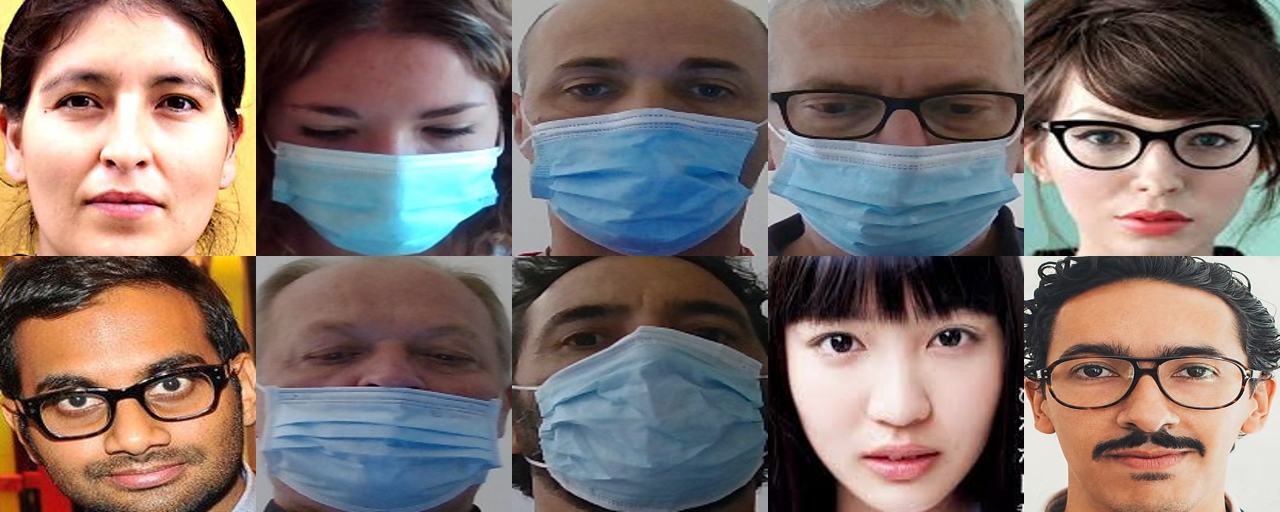

In [30]:
data_transform = transforms.Compose([transforms.ToPILImage(),  # Tensor of Numpy array to Pillow
                                    transforms.ToTensor(),          # Pillow to tensor [0-1]
                            ])   
# Tensor Dataset Che converte i dati da numpy a Pytorch
class ImageDataset(Dataset):
    def __init__(self, x,y,transform):
        self.transform = transform
        self.x = torch.from_numpy(x).type(torch.float32)
        self.y = torch.from_numpy(y).type(torch.LongTensor).reshape(-1)
    def __getitem__(self, index):
        x = self.x[index]
        if self.transform:
          x = self.transform(x)
        y = self.y[index]
        return x, y
    def __len__(self):
        return self.x.shape[0]

C_train_ds = ImageDataset(C_X_train,C_Y_train,data_transform)
C_test_ds = ImageDataset(C_X_test,C_Y_test,data_transform)

C_train_dl = torch.utils.data.DataLoader(C_train_ds,batch_size=10,shuffle=True)
for x,y in C_train_dl: 
    print(y)
    batch_grid =torchvision.utils.make_grid(x, nrow=5, padding=0)
    im = transforms.ToPILImage()(batch_grid*255)
    display(im)
    break

## Network

* [AdaptiveAvgPool2d](https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d)
* [AlexNet Pytorch](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html)

In [ ]:
def plot(outs):
    # nrows number of images in a row
    y = outs[1].unsqueeze(1)
    #print(y.shape)
    batch_grid =torchvision.utils.make_grid(y, nrow=8, padding=5,keep_channels=True).permute(1, 2, 0)
    #print(batch_grid.shape)
    fig = plt.figure(figsize=(20,10))
    plt.imshow(batch_grid, interpolation="nearest") #,aspect='auto')
    plt.axis('off')


In [31]:
class AlexNet(nn.Module):
    
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

x,y = next(iter(C_train_dl))
#print(x.shape)
net = AlexNet(num_classes=len(classes.keys()))
out = net.forward(x)
out

tensor([[-0.0145,  0.0069],
        [-0.0136,  0.0064],
        [-0.0157,  0.0025],
        [-0.0109,  0.0050],
        [-0.0160,  0.0067],
        [-0.0140,  0.0063],
        [-0.0163,  0.0059],
        [-0.0159,  0.0088],
        [-0.0160,  0.0088],
        [-0.0144,  0.0064]], grad_fn=<AddmmBackward>)

In [ ]:
# Example
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.reshape(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=-1)
        return x



## Training

In [32]:
# Validation: Metric Regression
def metrics_func_regression(target, output):
  # Comptue mean squaer error (Migliora quanto piu' ci avviciniamo a zero)
  mse = torch.sum((output - target) ** 2)
  return mse

# Validation: Metric cassification
def metrics_func_classification(target, output):
  # Compute number of correct prediction
  pred = output.argmax(dim=-1,keepdim=True)
  corrects =pred.eq(target.reshape(pred.shape)).sum().item()
  return -corrects # minus for coeherence with best result is the most negative one

# Training: Loss calculation and backward step
def loss_batch(loss_func,metric_func, xb,yb,yb_h, opt=None):
  # obtain loss
  loss = loss_func(yb_h, yb)
  # obtain permormance metric 
  metric_b = metric_func(yb,yb_h)
  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()
  return loss.item(), metric_b

# Trainig: Function 1 epoch
def loss_epoch(model, loss_func,metric_func, dataset_dl, opt, device):
  loss = 0.0
  metric = 0.0
  len_data = len(dataset_dl.dataset)
  # Get batch data
  for xb,yb in dataset_dl:    
    # Send to cuda the data (batch size)
    xb = xb.to(device)
    yb = yb.to(device)
    # obtain model output 
    yb_h = model.forward(xb)
    # Loss and Metric Calculation
    loss_b, metric_b = loss_batch(loss_func,metric_func, xb,yb,yb_h,opt)
    loss += loss_b
    if metric_b is not None:
      metric+=metric_b 
  loss /=len_data
  metric /=len_data
  return loss, metric

# Training: Iterate on epochs
def train_val(epochs, model, loss_func, metric_func, opt, train_dl,test_dl,device, path2weigths="./weights.pt"):
  lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.999) #  lr = lr * gamma ** last_epoch
  best_val_metric = 1000000
  for epoch in range(epochs):
    model.train()
    train_loss,train_metric = loss_epoch(model, loss_func, metric_func,train_dl, opt,device)
    lr_scheduler.step()
    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_func, metric_func, test_dl,opt=None,device=device)
      print("epoch: %d, train_loss: %.6f, val loss: %.6f,  train_metric: %.3f test_metric: %.3f lr: %.5f)" % (epoch,train_loss, val_loss,train_metric,val_metric,opt.param_groups[0]['lr']))
      if (val_metric <= best_val_metric):        
        # Save Models (It save last weights)
        torch.save(model.state_dict(),path2weigths)
        best_val_metric = val_metric


In [ ]:
# Setup GPU Device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print(device)

# Setup
C_model = AlexNet(len(classes.keys())).to(device)
C_loss_func = nn.CrossEntropyLoss(reduction="sum"); # nn.NLLLoss(reduction="sum")  #nn.BCELoss  
C_opt = optim.Adam(C_model.parameters(),lr=0.001)
C_train_dl = DataLoader(C_train_ds,batch_size=64,shuffle=True,num_workers=1)
C_test_dl = DataLoader(C_test_ds,batch_size=64,shuffle=True,num_workers=1)

# Train
train_val(200,C_model,C_loss_func,metrics_func_classification,C_opt, C_train_dl,C_test_dl,device,path2weigths="./weights_classification.pt")


## Test

In [42]:
# Load Classification
device = torch.device("cpu")
#classes = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,  'dog': 5,  'frog':6, 'horse':7, 'ship':8, 'truck':9}
classes = {'mask':0, 'no-mask':1}
C_model = AlexNet(len(classes)).to(device)
C_weights = torch.load("weights_classification.pt")
C_model.load_state_dict(C_weights)
C_model = C_model.to(device)

# Predict Classication
for x,y in C_test_dl:
  y_hat = C_model.forward(x).argmax(dim=-1,keepdim=True).detach().numpy().reshape(-1)

  # Visualize results
  cm = confusion_matrix(y,y_hat)
  names_pred = [ "Pred: " + n for n in classes]
  df = pd.DataFrame(cm, columns=names_pred, index=classes)
  display(df)

,Pred: mask,Pred: no-mask
mask,34,0
no-mask,0,30


,Pred: mask,Pred: no-mask
mask,32,0
no-mask,0,32


,Pred: mask,Pred: no-mask
mask,29,0
no-mask,2,33


,Pred: mask,Pred: no-mask
mask,32,1
no-mask,1,30


,Pred: mask,Pred: no-mask
mask,20,1
no-mask,0,23
